In [80]:
# Import libraries
import os
import os
import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
from scipy.integrate import simpson  
import pandas as pd

## Loading the Dataset

In [81]:
data_path = "dataset"

files = sorted([f for f in os.listdir(data_path) if f.endswith(".mat")])
print("Number of subjects:", len(files))
print(files)


Number of subjects: 27
['S10_A1_E1.mat', 'S11_A1_E1.mat', 'S12_A1_E1.mat', 'S13_A1_E1.mat', 'S14_A1_E1.mat', 'S15_A1_E1.mat', 'S16_A1_E1.mat', 'S17_A1_E1.mat', 'S18_A1_E1.mat', 'S19_A1_E1.mat', 'S1_A1_E1.mat', 'S20_A1_E1.mat', 'S21_A1_E1.mat', 'S22_A1_E1.mat', 'S23_A1_E1.mat', 'S24_A1_E1.mat', 'S25_A1_E1.mat', 'S26_A1_E1.mat', 'S27_A1_E1.mat', 'S2_A1_E1.mat', 'S3_A1_E1.mat', 'S4_A1_E1.mat', 'S5_A1_E1.mat', 'S6_A1_E1.mat', 'S7_A1_E1.mat', 'S8_A1_E1.mat', 'S9_A1_E1.mat']


In [82]:
all_subjects = []

for fname in files:
    fpath = os.path.join(data_path, fname)
    data = sio.loadmat(fpath)
    
    # Correct fields
    emg         = data["emg"]              # (N, 10)
    stimulus    = data["restimulus"].ravel()    # processed labels
    repetition  = data["rerepetition"].ravel()  # processed repetitions
    
    # Optional: rectified copy (we can use abs() later)
    emg_rectified = emg.copy()
    
    # Sanity check: same length
    assert emg.shape[0] == stimulus.shape[0] == repetition.shape[0], \
        f"Length mismatch in {fname}"
    
    subj = {
        "name": fname,
        "emg": emg,
        "emg_rectified": emg_rectified,
        "stimulus": stimulus,
        "repetition": repetition,
    }
    all_subjects.append(subj)

print("Loaded", len(all_subjects), "subjects.")

Loaded 27 subjects.


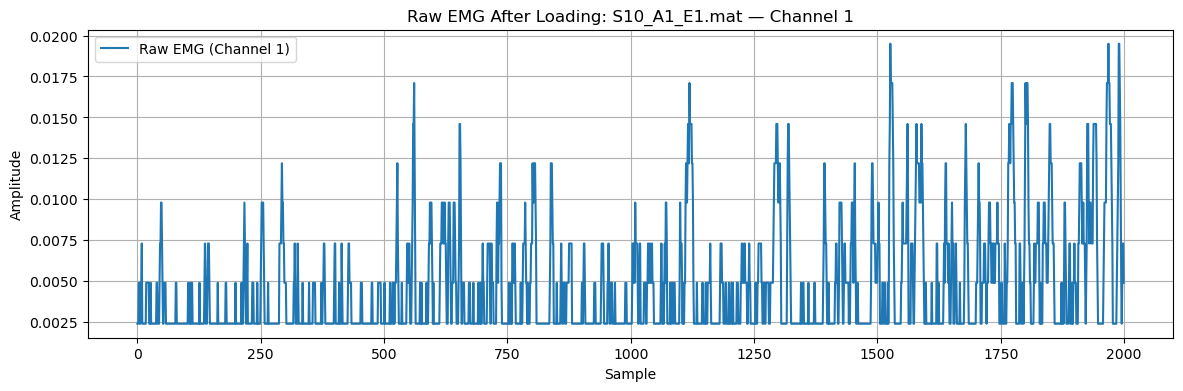

In [83]:
import matplotlib.pyplot as plt

# Pick the first subject and the first EMG channel
subj = all_subjects[0]
emg_raw = subj["emg"][:, 0]    # channel 1

# Plot first 2000 samples (20 seconds at 100 Hz)
plt.figure(figsize=(14,4))
plt.plot(emg_raw[:2000], label="Raw EMG (Channel 1)")
plt.title(f"Raw EMG After Loading: {subj['name']} — Channel 1")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.show()


In [84]:
for subj in all_subjects:
    print(f"\n{subj['name']}:")
    print("  EMG shape:", subj["emg"].shape)
    print("  Stimulus shape:", subj["stimulus"].shape,
          "unique:", np.unique(subj["stimulus"]))
    print("  Repetition shape:", subj["repetition"].shape,
          "unique:", np.unique(subj["repetition"]))


S10_A1_E1.mat:
  EMG shape: (100778, 10)
  Stimulus shape: (100778,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100778,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S11_A1_E1.mat:
  EMG shape: (100899, 10)
  Stimulus shape: (100899,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100899,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S12_A1_E1.mat:
  EMG shape: (100920, 10)
  Stimulus shape: (100920,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100920,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S13_A1_E1.mat:
  EMG shape: (100948, 10)
  Stimulus shape: (100948,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100948,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S14_A1_E1.mat:
  EMG shape: (100785, 10)
  Stimulus shape: (100785,) unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  Repetition shape: (100785,) unique: [ 0  1  2  3  4  5  6  7  8  9 10]

S15_A1_E1.mat:
  EMG shape: (101508, 10

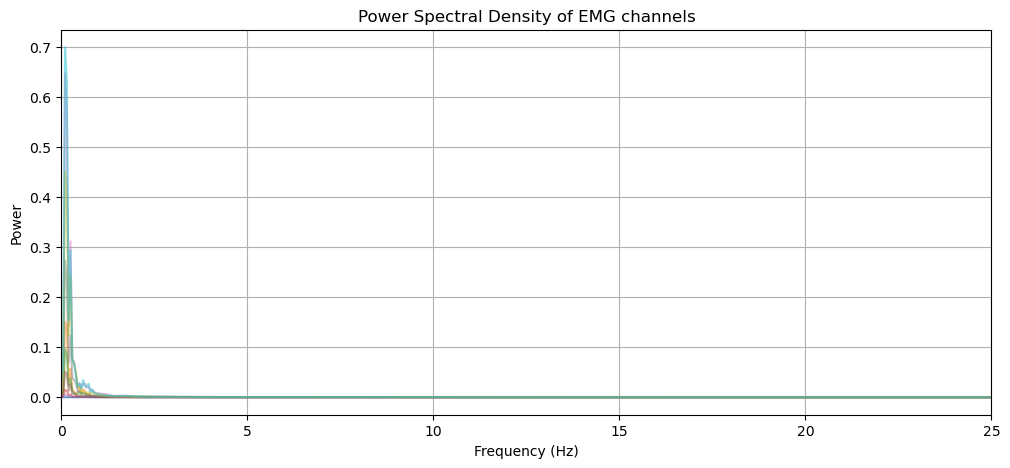

In [85]:
import matplotlib.pyplot as plt
from scipy.signal import welch

subj = all_subjects[0]          # check first subject
emg = subj["emg"]

fs = 100  # sampling rate

plt.figure(figsize=(12,5))

for ch in range(10):
    f, Pxx = welch(emg[:, ch], fs=fs, nperseg=2048)
    plt.plot(f, Pxx, alpha=0.5)

plt.title("Power Spectral Density of EMG channels")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.xlim(0, 25)
plt.grid(True)
plt.show()


## Applying Filters (was not a good idea:D )

In [86]:
from scipy.signal import butter, filtfilt

lowcut = 0.5      # high-pass cutoff
highcut = 40    # low-pass cutoff
order = 4       # Butterworth filter order

nyq = fs / 2
low = lowcut / nyq
high = highcut / nyq

# bandpass filter
b, a = butter(order, [low, high], btype='band')

In [87]:
for subj in all_subjects:
    emg = subj["emg"]           # shape (N, 10)
    emg_filt = np.zeros_like(emg)

    for ch in range(emg.shape[1]):  
        emg_filt[:, ch] = filtfilt(b, a, emg[:, ch])

    subj["emg_filt"] = emg_filt

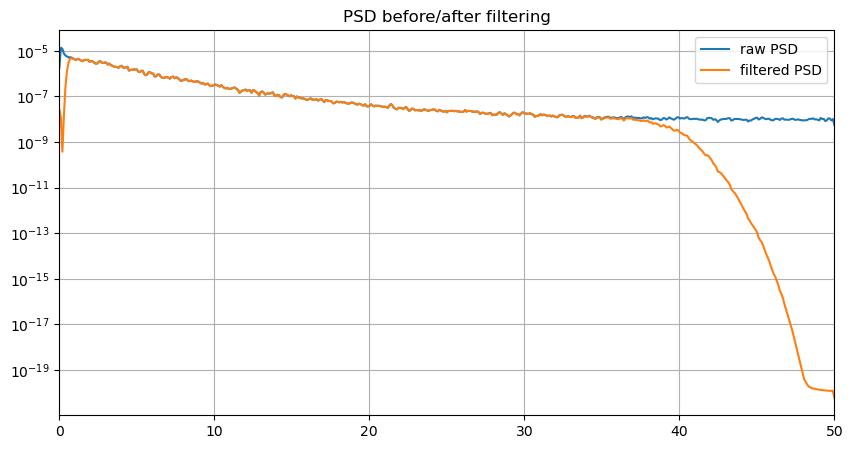

In [88]:
from scipy.signal import welch

f_raw, P_raw = welch(raw, fs=fs, nperseg=1024)
f_filt, P_filt = welch(filt, fs=fs, nperseg=1024)

plt.figure(figsize=(10,5))
plt.semilogy(f_raw, P_raw, label="raw PSD")
plt.semilogy(f_filt, P_filt, label="filtered PSD")
plt.xlim(0, 50)
plt.grid(True)
plt.legend()
plt.title("PSD before/after filtering")
plt.show()

In [89]:
n_stimuli = 12
n_repetitions = 10

emg_windows = [[None for _ in range(n_repetitions)] for _ in range(n_stimuli)]

for subj in all_subjects:
    
    stimuli = subj["stimulus"]
    reps = subj["repetition"]
    emg_filt = subj["emg_filt"]

    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):
            
            # build mask for this trial
            idx = np.logical_and(stimuli == stim_idx + 1,
                                 reps == rep_idx + 1)

            # extract filtered EMG (already envelope-like)
            current_window = emg_filt[idx, :]   
            
            # store it
            emg_windows[stim_idx][rep_idx] = current_window

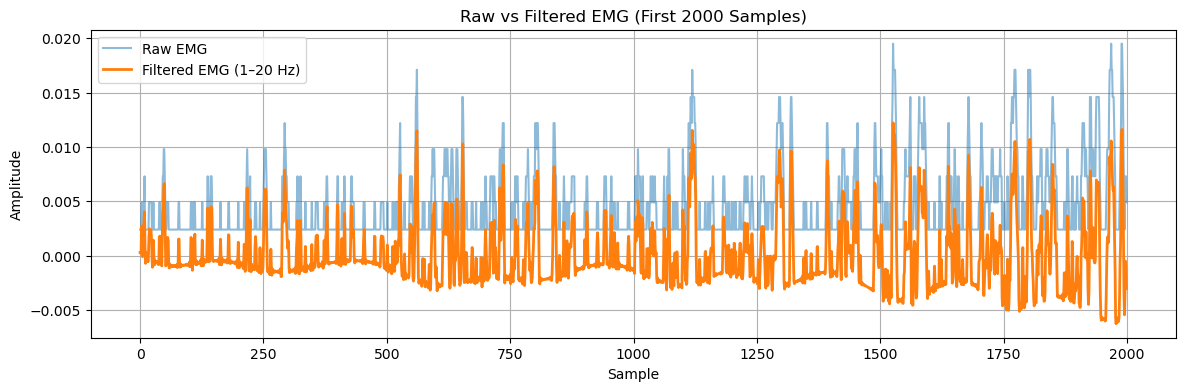

In [90]:
subj = all_subjects[0]   # first subject
raw = subj["emg"][:, 0]         # channel 1 raw
filt = subj["emg_filt"][:, 0]   # channel 1 filtered

plt.figure(figsize=(14,4))
plt.plot(raw[:2000], label="Raw EMG", alpha=0.5)
plt.plot(filt[:2000], label="Filtered EMG (1–20 Hz)", linewidth=2)
plt.title("Raw vs Filtered EMG (First 2000 Samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

## Windowing

In [91]:
import numpy as np

n_stimuli = 12
n_repetitions = 10

# Structure: emg_windows[stimulus][repetition] = EMG matrix (time × channels)
emg_windows = [[None for _ in range(n_repetitions)] 
               for _ in range(n_stimuli)]

for subj in all_subjects:

    emg = subj["emg"]                 # already processed EMG envelope
    stimulus = subj["stimulus"]
    repetition = subj["repetition"]

    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):

            # Create mask for this trial
            idx = np.logical_and(stimulus == stim_idx + 1,
                                 repetition == rep_idx + 1)

            # Extract EMG window for this trial
            current_window = emg[idx, :]

            # Store it
            emg_windows[stim_idx][rep_idx] = current_window


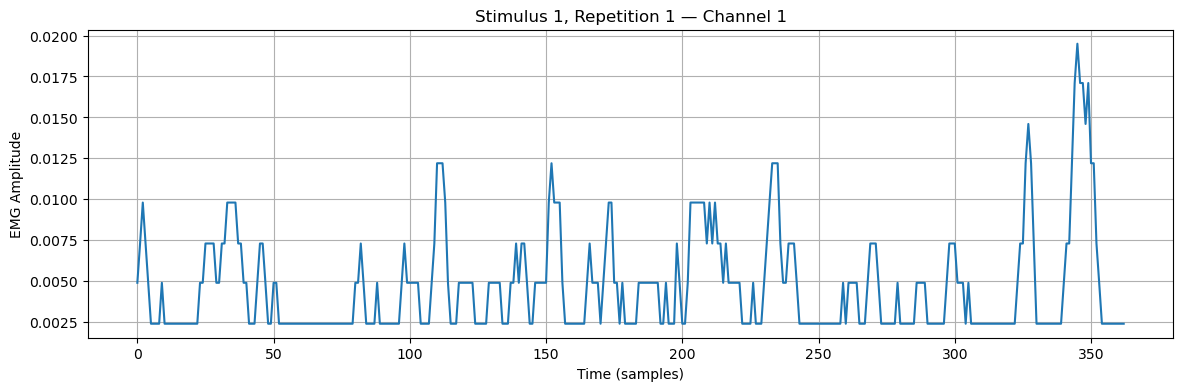

In [92]:
import matplotlib.pyplot as plt

stim_idx = 0
rep_idx = 0

window = emg_windows[stim_idx][rep_idx]

plt.figure(figsize=(14,4))
plt.plot(window[:, 0])
plt.title(f"Stimulus {stim_idx+1}, Repetition {rep_idx+1} — Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("EMG Amplitude")
plt.grid(True)
plt.show()

In [117]:
n_stimuli = 12
n_repetitions = 10

subject_windows = []   # list for each subject

for subj in all_subjects:

    emg = subj["emg"]
    stimulus = subj["stimulus"]
    repetition = subj["repetition"]

    # windows for THIS subject
    emg_windows_subj = [[None for _ in range(n_repetitions)] 
                         for _ in range(n_stimuli)]

    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):

            idx = np.logical_and(stimulus == stim_idx + 1,
                                 repetition == rep_idx + 1)

            emg_windows_subj[stim_idx][rep_idx] = emg[idx, :]

    subject_windows.append(emg_windows_subj)

print("Subjects processed:", len(subject_windows))

Subjects processed: 27


## Feature Exctraction

In [119]:
from scipy.integrate import simpson
from scipy.stats import skew, kurtosis


# 1. Root Mean Square (RMS)
def feat_rms(x):
    return np.sqrt(np.mean(x**2, axis=0))

# 2. Mean Absolute Value (MAV)
def feat_mav(x):
    return np.mean(np.abs(x), axis=0)

# 3. Waveform Length (WL)
def feat_wl(x):
    return np.sum(np.abs(np.diff(x, axis=0)), axis=0)

# 4. Variance
def feat_var(x):
    return np.var(x, axis=0)

# 5. Log Variance
def feat_logvar(x):
    return np.log(np.var(x, axis=0) + 1e-8)

# 6. Standard Deviation
def feat_std(x):
    return np.std(x, axis=0)

# 7. Maximum Absolute Value
def feat_maxav(x):
    return np.max(np.abs(x), axis=0)

# 8. Integrated EMG (IEMG)
def feat_iemg(x):
    return np.sum(np.abs(x), axis=0)

# 9. Willison Amplitude (WAMP)
def feat_wamp(x, thr=0.0005):
    return np.sum(np.abs(np.diff(x, axis=0)) >= thr, axis=0)

# 10. Hjorth Parameters
def feat_hjorth(x):
    d1 = np.diff(x, axis=0)
    d2 = np.diff(d1, axis=0)

    activity = np.var(x, axis=0)
    mobility = np.sqrt(np.var(d1, axis=0) / (activity + 1e-8))
    complexity = np.sqrt(np.var(d2, axis=0) / (np.var(d1, axis=0) + 1e-8)) / (mobility + 1e-8)

    return np.vstack([activity, mobility, complexity]).T  # shape = (channels, 3)

# 11. Skewness
def feat_skew(x):
    return skew(x, axis=0)

# 12. Kurtosis
def feat_kurt(x):
    return kurtosis(x, axis=0)

# 13. Bandpower in subbands (0–2, 2–5, 5–10, 10–20 Hz)
def feat_bandpower(x, fs=100):
    freqs, psd = welch(x, fs=fs, nperseg=min(256, len(x)), axis=0)

    bands = [(0, 2), (2, 5), (5, 10), (10, 20)]
    features = []

    for fmin, fmax in bands:
        idx = (freqs >= fmin) & (freqs <= fmax)
        bp = simpson(psd[idx, :], freqs[idx], axis=0)
        features.append(bp)

    return np.concatenate(features, axis=0)

# COMBINED FEATURE VECTOR FOR A WINDOW (one trial)

def extract_features(window, fs=100):
    feats = []

    feats.append(feat_rms(window))
    feats.append(feat_mav(window))
    feats.append(feat_wl(window))
    feats.append(feat_var(window))
    feats.append(feat_logvar(window))
    feats.append(feat_std(window))
    feats.append(feat_maxav(window))
    feats.append(feat_iemg(window))
    feats.append(feat_wamp(window))
    feats.append(feat_skew(window))
    feats.append(feat_kurt(window))
    feats.append(feat_bandpower(window, fs))

    # Hjorth returns (channels × 3) → flatten
    hj = feat_hjorth(window)
    feats.append(hj.flatten())

    # Final feature vector
    return np.concatenate(feats)

In [124]:
def generate_feature_names(n_channels=10):
    names = []

    # 1. RMS
    for ch in range(n_channels):
        names.append(f"RMS_ch{ch+1}")
        
    # 2. MAV
    for ch in range(n_channels):
        names.append(f"MAV_ch{ch+1}")

    # 3. Waveform Length (WL)
    for ch in range(n_channels):
        names.append(f"WL_ch{ch+1}")

    # 4. Variance
    for ch in range(n_channels):
        names.append(f"VAR_ch{ch+1}")

    # 5. Log-Variance
    for ch in range(n_channels):
        names.append(f"LOGVAR_ch{ch+1}")

    # 6. Standard Deviation
    for ch in range(n_channels):
        names.append(f"STD_ch{ch+1}")

    # 7. Max Absolute Value
    for ch in range(n_channels):
        names.append(f"MAXABS_ch{ch+1}")

    # 8. Integrated EMG (IEMG)
    for ch in range(n_channels):
        names.append(f"IEMG_ch{ch+1}")

    # 9. WAMP
    for ch in range(n_channels):
        names.append(f"WAMP_ch{ch+1}")

    # 10. Skewness
    for ch in range(n_channels):
        names.append(f"SKEW_ch{ch+1}")

    # 11. Kurtosis
    for ch in range(n_channels):
        names.append(f"KURT_ch{ch+1}")

    # 12. Bandpower (4 bands)
    bands = ["0-2Hz", "2-5Hz", "5-10Hz", "10-20Hz"]
    for band in bands:
        for ch in range(n_channels):
            names.append(f"BAND_{band}_ch{ch+1}")

    # 13. Hjorth Parameters (Activity, Mobility, Complexity)
    hjorth_params = ["Hj_Activity", "Hj_Mobility", "Hj_Complexity"]
    for param in hjorth_params:
        for ch in range(n_channels):
            names.append(f"{param}_ch{ch+1}")

    return names

# Create the full feature name list
feature_names = generate_feature_names(n_channels=10)

# Print how many features we have
print("Total number of features:", len(feature_names))

Total number of features: 180


In [120]:
subject_feature_means = []   # each entry = mean feature vector for subject
subject_feature_stds  = []   # each entry = std feature vector for subject

for subj_idx in range(len(subject_windows)):

    X_sub = []    # all feature vectors for this subject

    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):
            win = subject_windows[subj_idx][stim_idx][rep_idx]
            if win is None or len(win) == 0:
                continue
            X_sub.append(extract_features(win))

    X_sub = np.vstack(X_sub)

    subject_feature_means.append(np.mean(X_sub, axis=0))
    subject_feature_stds.append(np.std(X_sub, axis=0))


/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:54: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(x, axis=0)
/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return kurtosis(x, axis=0)


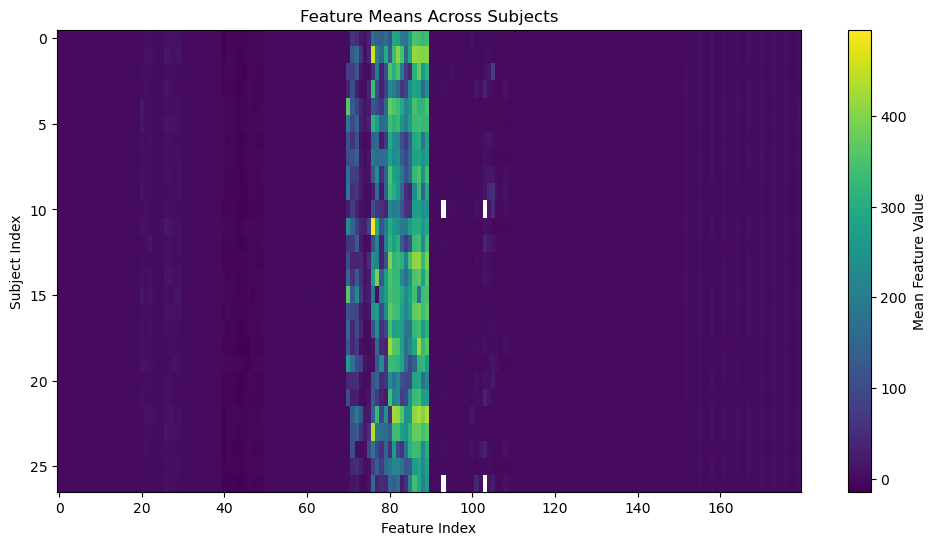

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.imshow(subject_feature_means, aspect='auto', cmap='viridis')
plt.colorbar(label="Mean Feature Value")
plt.xlabel("Feature Index")
plt.ylabel("Subject Index")
plt.title("Feature Means Across Subjects")
plt.show()


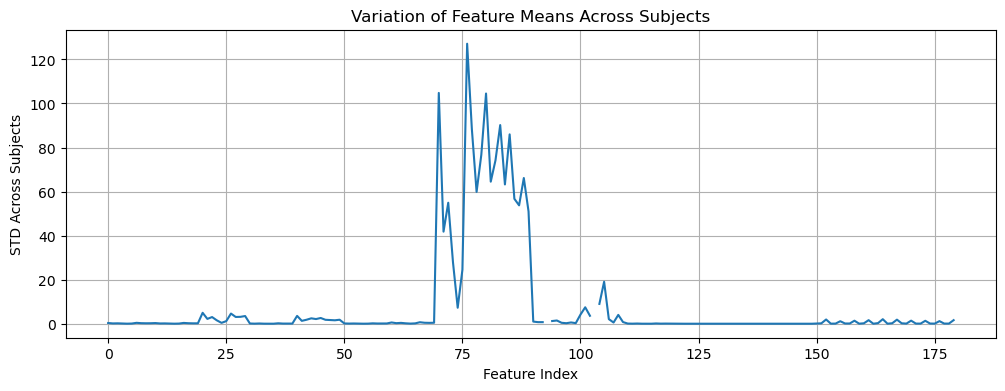

In [125]:
variation_across_subjects = np.std(subject_feature_means, axis=0)

plt.figure(figsize=(12,4))
plt.plot(variation_across_subjects)
plt.title("Variation of Feature Means Across Subjects")
plt.xlabel("Feature Index")
plt.ylabel("STD Across Subjects")
plt.grid(True)
plt.show()


In [126]:
most_variable = np.argsort(variation_across_subjects)[-10:]
most_stable   = np.argsort(variation_across_subjects)[:10]

print("Most stable features:")
for idx in most_stable:
    print(idx, feature_names[idx])

print("\nMost variable features:")
for idx in most_variable:
    print(idx, feature_names[idx])


Most stable features:
144 BAND_10-20Hz_ch5
134 BAND_5-10Hz_ch5
124 BAND_2-5Hz_ch5
145 BAND_10-20Hz_ch6
143 BAND_10-20Hz_ch4
135 BAND_5-10Hz_ch6
133 BAND_5-10Hz_ch4
125 BAND_2-5Hz_ch6
123 BAND_2-5Hz_ch4
147 BAND_10-20Hz_ch8

Most variable features:
82 WAMP_ch3
79 IEMG_ch10
85 WAMP_ch6
77 IEMG_ch8
83 WAMP_ch4
80 WAMP_ch1
70 IEMG_ch1
76 IEMG_ch7
103 KURT_ch4
93 SKEW_ch4


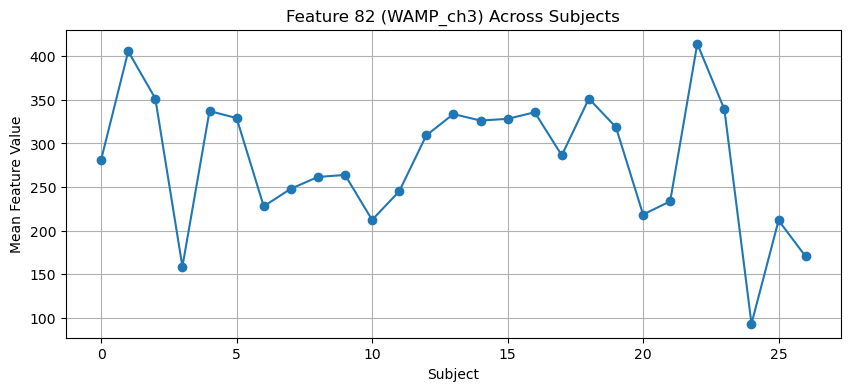

In [198]:
feat_idx = 82  # for example, RMS_ch7

plt.figure(figsize=(10,4))
plt.plot([mean[feat_idx] for mean in subject_feature_means], marker='o')
plt.title(f"Feature {feat_idx} ({feature_names[feat_idx]}) Across Subjects")
plt.xlabel("Subject")
plt.ylabel("Mean Feature Value")
plt.grid(True)
plt.show()


## Feature Selection

In [138]:
X = []
Y = []

for stim_idx in range(n_stimuli):
    for rep_idx in range(n_repetitions):

        window = emg_windows[stim_idx][rep_idx]

        if window is None or len(window) == 0:
            continue

        fv = extract_features(window)   # feature vector
        X.append(fv)
        Y.append(stim_idx + 1)          # class label

X = np.vstack(X)
Y = np.array(Y)


/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:54: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(x, axis=0)
/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return kurtosis(x, axis=0)


In [139]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("Number of features:", X.shape[1])
print("Number of samples:", X.shape[0])

X shape: (120, 180)
Y shape: (120,)
Number of features: 180
Number of samples: 120


In [141]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

print("NaN left:", np.isnan(X).sum())

NaN left: 0


In [149]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

print("NaN after cleaning:", np.isnan(X).sum())
print("Inf after cleaning:", np.isinf(X).sum())

NaN after cleaning: 0
Inf after cleaning: 0


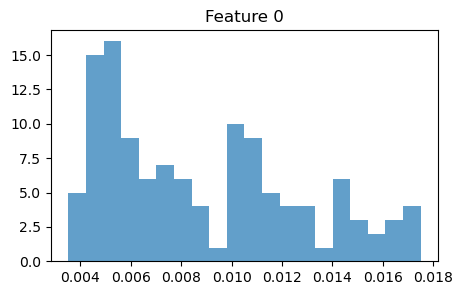

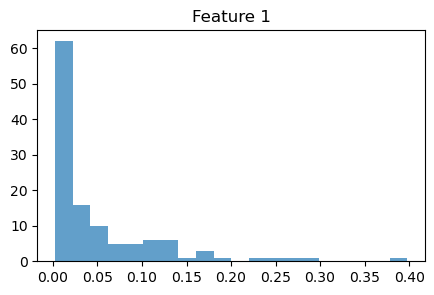

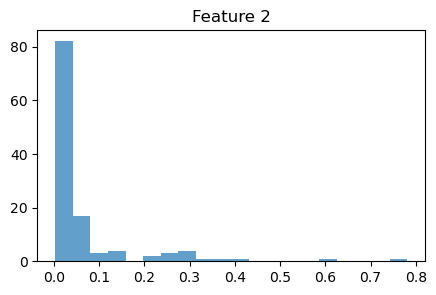

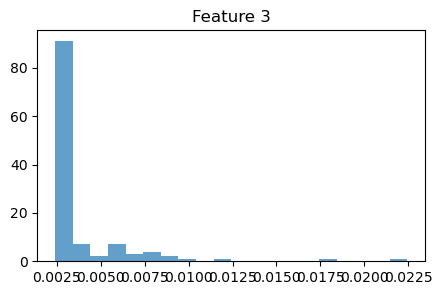

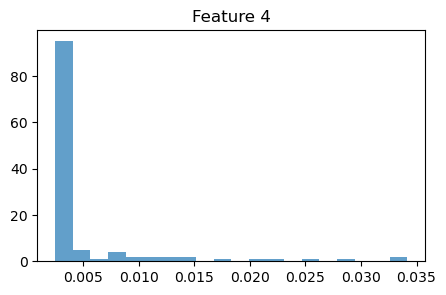

In [143]:
import matplotlib.pyplot as plt

for i in range(5):   # first 6 features
    plt.figure(figsize=(5,3))
    plt.hist(X[:, i], bins=20, alpha=0.7)
    plt.title(f"Feature {i}")
    plt.show()

In [144]:
from sklearn.feature_selection import mutual_info_classif

# Compute Mutual Information for each feature
MI = mutual_info_classif(X, Y, discrete_features=False)

# Sort features by MI (descending)
mi_rank = np.argsort(MI)[::-1]

# Top 5 features
top20_mi = mi_rank[:20]


print("\nNames:")
for idx in top20_mi:
    print(idx, feature_names[idx])


Names:
6 RMS_ch7
15 MAV_ch6
16 MAV_ch7
75 IEMG_ch6
25 WL_ch6
19 MAV_ch10
5 RMS_ch6
76 IEMG_ch7
59 STD_ch10
39 VAR_ch10
177 Hj_Complexity_ch8
29 WL_ch10
49 LOGVAR_ch10
9 RMS_ch10
135 BAND_5-10Hz_ch6
66 MAXABS_ch7
145 BAND_10-20Hz_ch6
79 IEMG_ch10
26 WL_ch7
56 STD_ch7


In [161]:
from skfeature.function.information_theoretical_based import MRMR

# MRMR wants X as numpy array and y as 1D array
mrmr_indices = MRMR.mrmr(X, Y, n_selected_features=20)

top20_mrmr = mrmr_indices[:20]
print("Top 20 mRMR features:", top20_mrmr)

print("\nNames:")
for idx in top20_mrmr:
    print(idx, feature_names[idx])



Top 20 mRMR features: [179 115 116  94 113 119 118 117 114  98  91  95  90  96 110  92 112  93
 158  68]

Names:
179 Hj_Complexity_ch10
115 BAND_0-2Hz_ch6
116 BAND_0-2Hz_ch7
94 SKEW_ch5
113 BAND_0-2Hz_ch4
119 BAND_0-2Hz_ch10
118 BAND_0-2Hz_ch9
117 BAND_0-2Hz_ch8
114 BAND_0-2Hz_ch5
98 SKEW_ch9
91 SKEW_ch2
95 SKEW_ch6
90 SKEW_ch1
96 SKEW_ch7
110 BAND_0-2Hz_ch1
92 SKEW_ch3
112 BAND_0-2Hz_ch3
93 SKEW_ch4
158 Hj_Activity_ch9
68 MAXABS_ch9


In [ ]:
print("Top 5 MI feature indices:", list(top20_mi))
print("Top 5 mRMR feature indices:", top20_mrmr)

# Convert to set for easier comparison
mi_set = set(top20_mi)
mrmr_set = set(top20_mrmr)

print("\nCommon features:", mi_set & mrmr_set)
print("Unique to MI:", mi_set - mrmr_set)
print("Unique to mRMR:", mrmr_set - mi_set)


Top 5 MI feature indices: [6, 15, 16, 75, 25, 19, 5, 76, 59, 39, 177, 29, 49, 9, 135, 66, 145, 79, 26, 56]
Top 5 mRMR feature indices: [179 115 116  94 113 119 118 117 114  98  91  95  90  96 110  92 112  93
 158  68]

Common features: set()
Unique to MI: {5, 6, 135, 9, 15, 16, 145, 19, 25, 26, 29, 39, 177, 49, 56, 59, 66, 75, 76, 79}
Unique to mRMR: {158, 179, 68, 90, 91, 92, 93, 94, 95, 96, 98, 110, 112, 113, 114, 115, 116, 117, 118, 119}


## Classification + Cross-Validation

In [186]:
from sklearn.preprocessing import StandardScaler

subject_features = []

for subj_idx in range(len(subject_windows)):
    X_sub = []
    Y_sub = []

    # --- extract features for this subject ---
    for stim_idx in range(n_stimuli):
        for rep_idx in range(n_repetitions):
            win = subject_windows[subj_idx][stim_idx][rep_idx]
            if win is None or len(win) == 0:
                continue

            fv = extract_features(win)[top20_mrmr]
            X_sub.append(fv)
            Y_sub.append(stim_idx + 1)

    # --- convert to arrays ---
    X_sub = np.vstack(X_sub)
    Y_sub = np.array(Y_sub)

    # --- 1) remove NaN ---
    imputer = SimpleImputer(strategy="mean")
    X_sub = imputer.fit_transform(X_sub)

    # --- 2) normalize THIS SUBJECT ONLY ---
    scaler = StandardScaler()
    X_sub = scaler.fit_transform(X_sub)

    # --- store clean data ---
    subject_features.append({
        "X": X_sub,
        "Y": Y_sub
    })

print("Done building normalized subject_features.")


/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:54: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(x, axis=0)
/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return kurtosis(x, axis=0)
/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:54: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(x, axis=0)
/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastr

Done building normalized subject_features.


/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:54: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return skew(x, axis=0)
/var/folders/vx/lzkwv7v11wxd2pk5slj73zgw0000gn/T/ipykernel_22327/1222099677.py:58: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return kurtosis(x, axis=0)


In [193]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

loso_accuracies = []
loso_predictions = []

for test_idx in range(len(subject_features)):

    # Build training set from the other 26 subjects
    X_train = []
    Y_train = []

    for i in range(len(subject_features)):
        if i != test_idx:
            X_train.append(subject_features[i]["X"])
            Y_train.append(subject_features[i]["Y"])

    X_train = np.vstack(X_train)
    Y_train = np.hstack(Y_train)

    # Test subject
    X_test = subject_features[test_idx]["X"]
    Y_test = subject_features[test_idx]["Y"]

    # Train the SVM
    clf = SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train, Y_train)

    # Predict
    Y_pred = clf.predict(X_test)
    loso_predictions.append((Y_test, Y_pred))

    # Accuracy
    acc = accuracy_score(Y_test, Y_pred)
    loso_accuracies.append(acc)
    
    print(f"Subject {test_idx+1}: LOSO accuracy = {acc:.3f}")

# Summary
print("\nMean LOSO accuracy:", np.mean(loso_accuracies))
print("STD across subjects:", np.std(loso_accuracies))


Subject 1: LOSO accuracy = 0.242
Subject 2: LOSO accuracy = 0.283
Subject 3: LOSO accuracy = 0.350
Subject 4: LOSO accuracy = 0.400
Subject 5: LOSO accuracy = 0.425
Subject 6: LOSO accuracy = 0.450
Subject 7: LOSO accuracy = 0.342
Subject 8: LOSO accuracy = 0.417
Subject 9: LOSO accuracy = 0.317
Subject 10: LOSO accuracy = 0.408
Subject 11: LOSO accuracy = 0.283
Subject 12: LOSO accuracy = 0.325
Subject 13: LOSO accuracy = 0.442
Subject 14: LOSO accuracy = 0.375
Subject 15: LOSO accuracy = 0.325
Subject 16: LOSO accuracy = 0.317
Subject 17: LOSO accuracy = 0.433
Subject 18: LOSO accuracy = 0.458
Subject 19: LOSO accuracy = 0.242
Subject 20: LOSO accuracy = 0.158
Subject 21: LOSO accuracy = 0.458
Subject 22: LOSO accuracy = 0.333
Subject 23: LOSO accuracy = 0.325
Subject 24: LOSO accuracy = 0.408
Subject 25: LOSO accuracy = 0.225
Subject 26: LOSO accuracy = 0.475
Subject 27: LOSO accuracy = 0.350

Mean LOSO accuracy: 0.35432098765432096
STD across subjects: 0.08007103232726914


In [194]:
from sklearn.model_selection import train_test_split

within_acc = []

for subj_idx in range(len(subject_features)):
    X = subject_features[subj_idx]["X"]
    Y = subject_features[subj_idx]["Y"]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=0
    )

    clf = SVC(kernel='rbf', gamma='scale', C=10)
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    acc = accuracy_score(Y_test, Y_pred)
    within_acc.append(acc)

    print(f"Subject {subj_idx+1}: Within-subject accuracy = {acc:.3f}")

Subject 1: Within-subject accuracy = 0.833
Subject 2: Within-subject accuracy = 0.875
Subject 3: Within-subject accuracy = 0.875
Subject 4: Within-subject accuracy = 0.833
Subject 5: Within-subject accuracy = 0.833
Subject 6: Within-subject accuracy = 0.667
Subject 7: Within-subject accuracy = 0.792
Subject 8: Within-subject accuracy = 0.792
Subject 9: Within-subject accuracy = 0.833
Subject 10: Within-subject accuracy = 0.708
Subject 11: Within-subject accuracy = 0.750
Subject 12: Within-subject accuracy = 0.875
Subject 13: Within-subject accuracy = 0.958
Subject 14: Within-subject accuracy = 0.833
Subject 15: Within-subject accuracy = 0.750
Subject 16: Within-subject accuracy = 0.625
Subject 17: Within-subject accuracy = 0.833
Subject 18: Within-subject accuracy = 0.917
Subject 19: Within-subject accuracy = 0.708
Subject 20: Within-subject accuracy = 0.708
Subject 21: Within-subject accuracy = 0.792
Subject 22: Within-subject accuracy = 0.792
Subject 23: Within-subject accuracy = 0.8

In [195]:
print("\n=== SUMMARY ===")
print("Mean LOSO accuracy (cross-subject):", np.mean(loso_accuracies))
print("Mean within-subject accuracy:", np.mean(within_acc))



=== SUMMARY ===
Mean LOSO accuracy (cross-subject): 0.35432098765432096
Mean within-subject accuracy: 0.7870370370370371


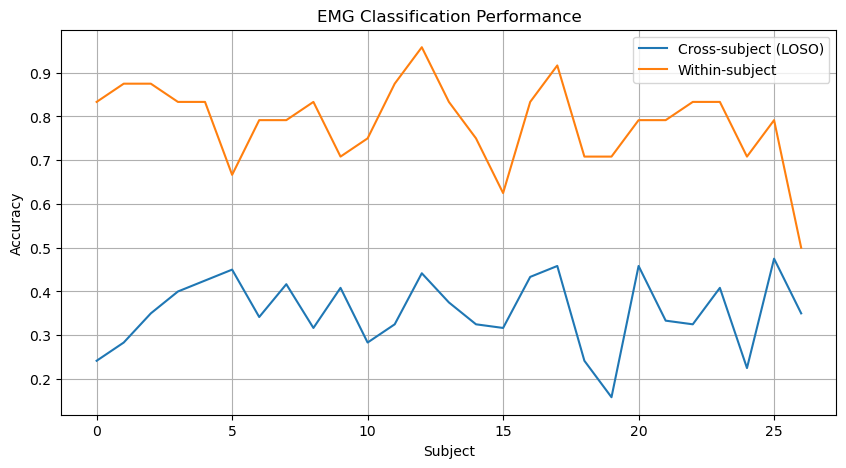

In [196]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(loso_accuracies, label="Cross-subject (LOSO)")
plt.plot(within_acc, label="Within-subject")
plt.title("EMG Classification Performance")
plt.xlabel("Subject")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


The LOSO cross-validation evaluates how well the model generalizes to a subject that was never seen during training. The results show a large drop in accuracy compared to within-subject evaluation. This happens because EMG signals vary strongly between subjects due to differences in muscle physiology, skin impedance, electrode placement, and activation patterns. As a result, a model trained on 26 subjects transfers only partially to the remaining subject.

## Decoder (Optimal number of subjects for training)

Train subjects:  1, accuracy on subject 27: 0.200
Train subjects:  2, accuracy on subject 27: 0.183
Train subjects:  3, accuracy on subject 27: 0.317
Train subjects:  4, accuracy on subject 27: 0.292
Train subjects:  5, accuracy on subject 27: 0.308
Train subjects:  6, accuracy on subject 27: 0.342
Train subjects:  7, accuracy on subject 27: 0.358
Train subjects:  8, accuracy on subject 27: 0.325
Train subjects:  9, accuracy on subject 27: 0.325
Train subjects: 10, accuracy on subject 27: 0.367
Train subjects: 11, accuracy on subject 27: 0.350
Train subjects: 12, accuracy on subject 27: 0.342
Train subjects: 13, accuracy on subject 27: 0.292
Train subjects: 14, accuracy on subject 27: 0.317
Train subjects: 15, accuracy on subject 27: 0.292
Train subjects: 16, accuracy on subject 27: 0.350
Train subjects: 17, accuracy on subject 27: 0.325
Train subjects: 18, accuracy on subject 27: 0.325
Train subjects: 19, accuracy on subject 27: 0.292
Train subjects: 20, accuracy on subject 27: 0.308


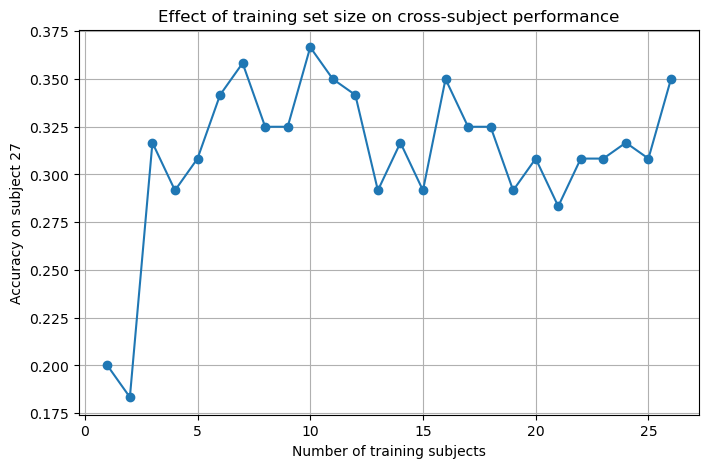

In [197]:
n_subjects = len(subject_features)
test_idx = 26   # subject 27 (0-based index)

# training order: all subjects except test subject
train_order = [i for i in range(n_subjects) if i != test_idx]

acc_vs_n = []

for k in range(1, len(train_order) + 1):
    # use first k subjects in train_order as training set
    train_idxs = train_order[:k]

    X_train = np.vstack([subject_features[i]["X"] for i in train_idxs])
    Y_train = np.hstack([subject_features[i]["Y"] for i in train_idxs])

    X_test = subject_features[test_idx]["X"]
    Y_test = subject_features[test_idx]["Y"]

    clf = SVC(kernel='rbf', C=10, gamma='scale')
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    acc = accuracy_score(Y_test, Y_pred)
    acc_vs_n.append(acc)

    print(f"Train subjects: {k:2d}, accuracy on subject {test_idx+1}: {acc:.3f}")

# Plot accuracy vs number of training subjects
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_order) + 1), acc_vs_n, marker='o')
plt.xlabel("Number of training subjects")
plt.ylabel(f"Accuracy on subject {test_idx+1}")
plt.title("Effect of training set size on cross-subject performance")
plt.grid(True)
plt.show()


As the number of training subjects increased, the model’s performance on the held-out subject improved initially but quickly reached a plateau. When trained on only 1–3 subjects, accuracy was very low (≈18–22%), showing that the model cannot generalize with such limited inter-subject variability. Performance increased sharply once 4–7 subjects were included (≈30–34%), indicating the minimum dataset size required for a model that begins to generalize. The highest accuracy was achieved when training on approximately 10 subjects (≈37%). Beyond 10 subjects, adding more data did not consistently improve accuracy